# ASSIGNMENT - 771763 - Understanding AI - Multi-Object Recogniser
## Student ID - 202102828

In [1]:
# libraries for data processing and visualisation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msn

# image processing
import PIL

import pathlib

# libraries for machine learning (createing models)
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import tensorflow as tf
from tensorflow.keras import layers


---
Reading the dataset and splitting it into training and validation data
---

In [2]:
data_dir = './vehicles_images'

batch_size = 32
img_height = 160
img_width = 160

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
class_names = train_ds.class_names
class_names

Found 4318 files belonging to 4 classes.
Using 3455 files for training.
Found 4318 files belonging to 4 classes.
Using 863 files for validation.


['bus', 'motorcycle', 'plane', 'train']

#### caching the images

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(3500).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

0.0004901961 1.0


##### First model

In [4]:
model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

In [6]:
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/10
108/108 [==============================] - 24s 224ms/step - loss: 1.2566 - accuracy: 0.4397 - val_loss: 1.1042 - val_accuracy: 0.5249
Epoch 2/10
108/108 [==============================] - 24s 224ms/step - loss: 1.0160 - accuracy: 0.5763 - val_loss: 0.9915 - val_accuracy: 0.6014
Epoch 3/10
108/108 [==============================] - 24s 223ms/step - loss: 0.8746 - accuracy: 0.6582 - val_loss: 0.9325 - val_accuracy: 0.6211
Epoch 4/10
108/108 [==============================] - 24s 221ms/step - loss: 0.7497 - accuracy: 0.7074 - val_loss: 0.9615 - val_accuracy: 0.6269
Epoch 5/10
108/108 [==============================] - 24s 222ms/step - loss: 0.6014 - accuracy: 0.7679 - val_loss: 1.2139 - val_accuracy: 0.5214
Epoch 6/10
108/108 [==============================] - 24s 222ms/step - loss: 0.4282 - accuracy: 0.8457 - val_loss: 1.2762 - val_accuracy: 0.5956
Epoch 7/10
108/108 [==============================] - 24s 222ms/step - loss: 0.3201 - accuracy: 0.8967 - val_loss: 1.2753 - val_ac

Function to plot the relation

In [7]:
def plot_graph(history, n, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Training and Validation Loss')
    plt.savefig('vehicle_nn_' + str(n) + '.png')
    plt.show()

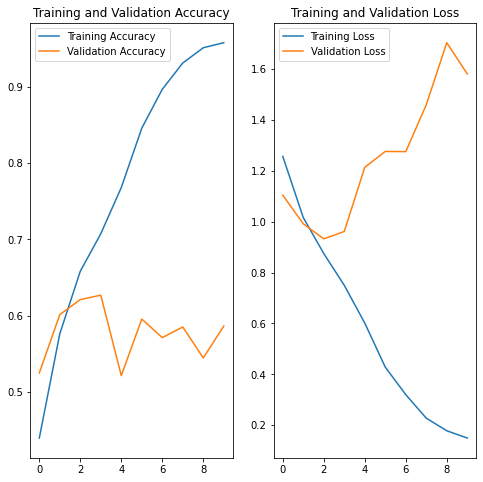

In [8]:
plot_graph(history, 1, epochs)

##### Second model

In [9]:
model_2 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(20, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(40, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(160, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(240, activation='relu'),
    layers.Dense(num_classes)
])

model_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [10]:
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
108/108 [==============================] - 80s 742ms/step - loss: 1.3565 - accuracy: 0.3467 - val_loss: 1.2879 - val_accuracy: 0.4253
Epoch 2/10
108/108 [==============================] - 79s 736ms/step - loss: 1.1857 - accuracy: 0.4868 - val_loss: 1.0974 - val_accuracy: 0.5203
Epoch 3/10
108/108 [==============================] - 80s 738ms/step - loss: 1.0982 - accuracy: 0.5427 - val_loss: 1.1083 - val_accuracy: 0.5203
Epoch 4/10
108/108 [==============================] - 80s 738ms/step - loss: 0.9994 - accuracy: 0.5844 - val_loss: 0.9656 - val_accuracy: 0.6141
Epoch 5/10
108/108 [==============================] - 80s 738ms/step - loss: 0.9206 - accuracy: 0.6295 - val_loss: 1.0045 - val_accuracy: 0.5840
Epoch 6/10
108/108 [==============================] - 79s 735ms/step - loss: 0.8454 - accuracy: 0.6570 - val_loss: 0.9568 - val_accuracy: 0.6037
Epoch 7/10
108/108 [==============================] - 80s 741ms/step - loss: 0.7894 - accuracy: 0.6828 - val_loss: 1.0029 - val_ac

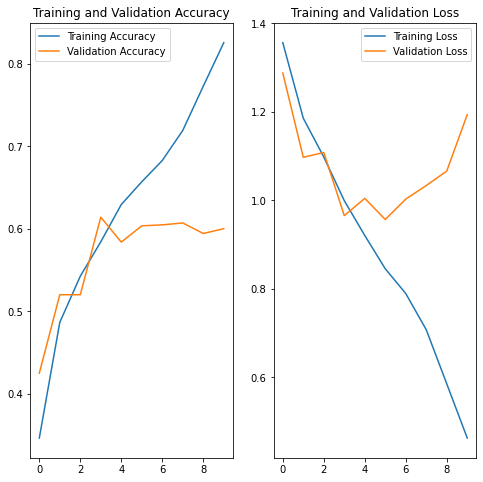

In [11]:
plot_graph(history_2, 2, epochs)

##### Third model

In [12]:
model_3 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(30, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(60, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(120, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(240, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(240, activation='relu'),
    layers.Dense(num_classes)
])

model_3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [13]:
history_3 = model_3.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
108/108 [==============================] - 133s 1s/step - loss: 1.3404 - accuracy: 0.3806 - val_loss: 1.2108 - val_accuracy: 0.4867
Epoch 2/10
108/108 [==============================] - 133s 1s/step - loss: 1.1207 - accuracy: 0.5198 - val_loss: 1.0529 - val_accuracy: 0.5863
Epoch 3/10
108/108 [==============================] - 133s 1s/step - loss: 1.0437 - accuracy: 0.5705 - val_loss: 1.0815 - val_accuracy: 0.5527
Epoch 4/10
108/108 [==============================] - 133s 1s/step - loss: 0.9784 - accuracy: 0.5951 - val_loss: 0.9781 - val_accuracy: 0.6060
Epoch 5/10
108/108 [==============================] - 133s 1s/step - loss: 0.9383 - accuracy: 0.6159 - val_loss: 0.9475 - val_accuracy: 0.6188
Epoch 6/10
108/108 [==============================] - 133s 1s/step - loss: 0.8570 - accuracy: 0.6524 - val_loss: 0.9075 - val_accuracy: 0.6373
Epoch 7/10
108/108 [==============================] - 133s 1s/step - loss: 0.7948 - accuracy: 0.6834 - val_loss: 1.1184 - val_accuracy: 0.5724

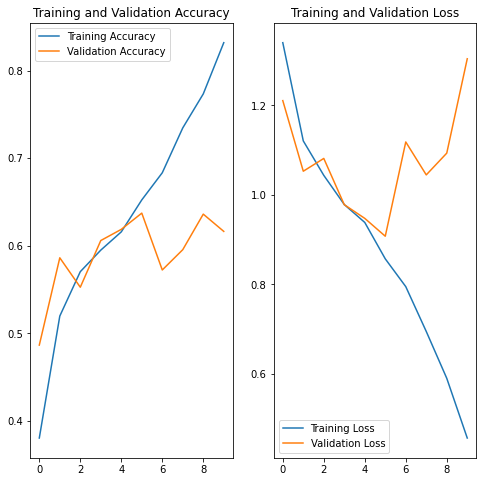

In [14]:
plot_graph(history_3, 3, epochs)

##### Fourth model

In [15]:
model_4 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(20, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(40, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(160, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(240, activation='relu'),
    layers.Dense(num_classes)
])

model_4.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [16]:
history_4 = model_4.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
108/108 [==============================] - 80s 739ms/step - loss: 1.2840 - accuracy: 0.4217 - val_loss: 1.4076 - val_accuracy: 0.4171
Epoch 2/10
108/108 [==============================] - 80s 738ms/step - loss: 1.1000 - accuracy: 0.5204 - val_loss: 1.0448 - val_accuracy: 0.5632
Epoch 3/10
108/108 [==============================] - 80s 738ms/step - loss: 1.0411 - accuracy: 0.5763 - val_loss: 1.0080 - val_accuracy: 0.5944
Epoch 4/10
108/108 [==============================] - 81s 747ms/step - loss: 0.9716 - accuracy: 0.6061 - val_loss: 1.1540 - val_accuracy: 0.4890
Epoch 5/10
108/108 [==============================] - 80s 740ms/step - loss: 0.9409 - accuracy: 0.6116 - val_loss: 0.9650 - val_accuracy: 0.5933
Epoch 6/10
108/108 [==============================] - 81s 746ms/step - loss: 0.8632 - accuracy: 0.6527 - val_loss: 0.9340 - val_accuracy: 0.6362
Epoch 7/10
108/108 [==============================] - 80s 744ms/step - loss: 0.8066 - accuracy: 0.6880 - val_loss: 1.0544 - val_ac

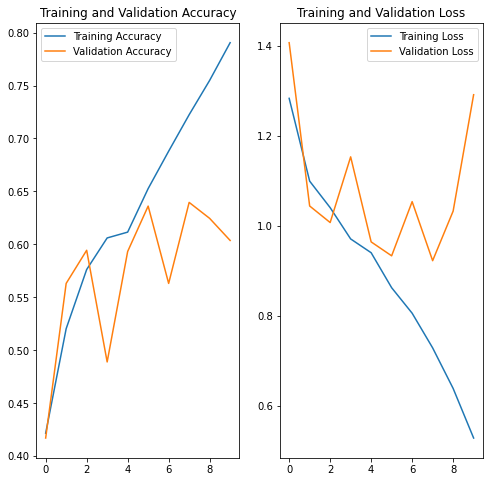

In [17]:
plot_graph(history_4, 4, epochs)

Printing the images

(32, 160, 160, 3)
(32,)


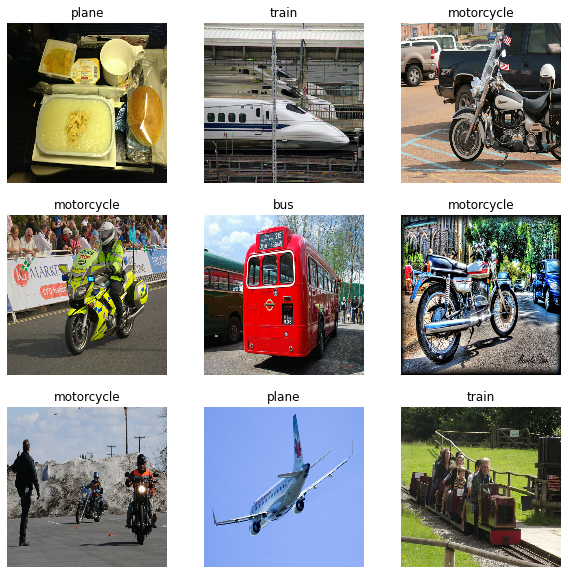

In [18]:
plt.figure(figsize=(10, 10))
for images, labels, in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

---
Data Augmentation
---

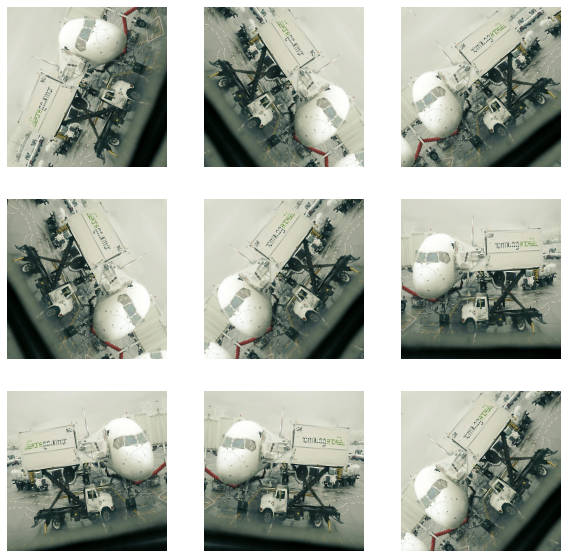

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

for image, _ in train_ds.take(1):
    plt.figure(figsize = (10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [20]:
model_5 = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(20, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(40, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(80, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(160, 6, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(240, activation='relu'),
    layers.Dense(num_classes)
])

model_5.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [21]:
history_5 = model_5.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
108/108 [==============================] - 81s 746ms/step - loss: 1.2352 - accuracy: 0.4365 - val_loss: 1.2449 - val_accuracy: 0.5017
Epoch 2/10
108/108 [==============================] - 80s 741ms/step - loss: 1.1059 - accuracy: 0.5274 - val_loss: 1.0192 - val_accuracy: 0.5747
Epoch 3/10
108/108 [==============================] - 79s 735ms/step - loss: 1.0140 - accuracy: 0.5812 - val_loss: 0.9781 - val_accuracy: 0.6037
Epoch 4/10
108/108 [==============================] - 79s 735ms/step - loss: 0.9579 - accuracy: 0.6061 - val_loss: 0.9826 - val_accuracy: 0.6002
Epoch 5/10
108/108 [==============================] - 80s 740ms/step - loss: 0.8934 - accuracy: 0.6452 - val_loss: 0.9233 - val_accuracy: 0.6327
Epoch 6/10
108/108 [==============================] - 79s 736ms/step - loss: 0.8257 - accuracy: 0.6726 - val_loss: 0.9363 - val_accuracy: 0.6373
Epoch 7/10
108/108 [==============================] - 79s 735ms/step - loss: 0.7556 - accuracy: 0.7027 - val_loss: 0.9369 - val_ac

---
Imagenet
---

In [22]:
#IMG_SHAPE = tf.image.resize(images, [160, 160])
base_model = tf.keras.applications.MobileNetV2(input_shape=None, include_top=False, weights='imagenet')
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
base_model.trainable = False
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [24]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [25]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

print("Initial Loss: {:.2f}".format(loss0))
print("Initial accuracy: {:.2f}".format(accuracy0))

history = model.fit(train_ds, validation_data=val_ds, epochs=initial_epochs)

c:\users\mathews\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                             

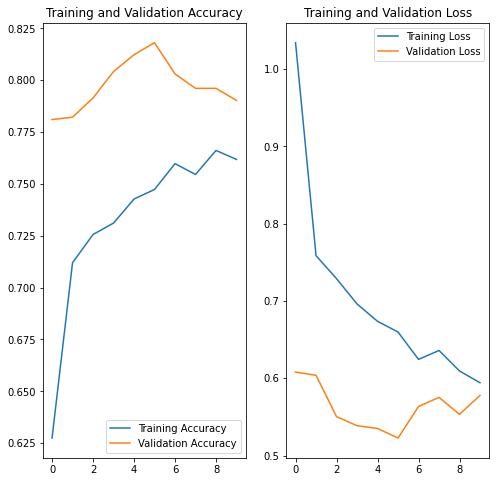

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
    
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.savefig('vehicle_nn_post_imagenet.png')
plt.show()

---
Fine-tuning
---

In [28]:
base_model.trainable = True
base_model.summary()

print('Number of layers in the base model: ', len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

c:\users\mathews\appdata\local\programs\python\python38\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [30]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                        epochs=total_epochs,
                        initial_epoch=history.epoch[-1],
                        validation_data=val_ds)

Epoch 10/20
108/108 [==============================] - 45s 393ms/step - loss: 0.5661 - accuracy: 0.7725 - val_loss: 0.5235 - val_accuracy: 0.8169
Epoch 11/20
108/108 [==============================] - 42s 390ms/step - loss: 0.5305 - accuracy: 0.7878 - val_loss: 0.5125 - val_accuracy: 0.8192
Epoch 12/20
108/108 [==============================] - 42s 390ms/step - loss: 0.5034 - accuracy: 0.7997 - val_loss: 0.5077 - val_accuracy: 0.8297
Epoch 13/20
108/108 [==============================] - 42s 391ms/step - loss: 0.4904 - accuracy: 0.8072 - val_loss: 0.5189 - val_accuracy: 0.8204
Epoch 14/20
108/108 [==============================] - 42s 391ms/step - loss: 0.4598 - accuracy: 0.8148 - val_loss: 0.5053 - val_accuracy: 0.8250
Epoch 15/20
108/108 [==============================] - 42s 390ms/step - loss: 0.4642 - accuracy: 0.8226 - val_loss: 0.5141 - val_accuracy: 0.8285
Epoch 16/20
108/108 [==============================] - 42s 391ms/step - loss: 0.4390 - accuracy: 0.8258 - val_loss: 0.5294 -

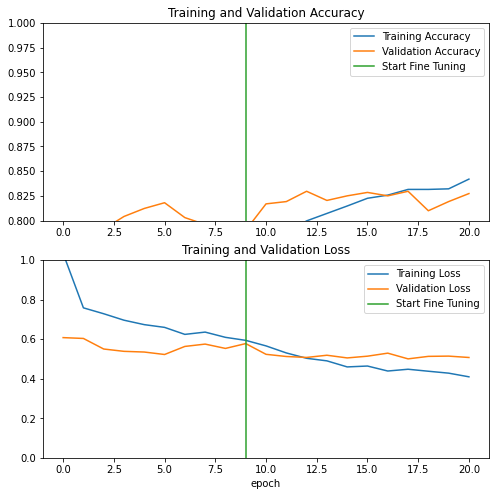

27/27 [==============================] - 6s 232ms/step - loss: 0.5075 - accuracy: 0.8273
Test accuracy : 0.8273464441299438


In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize = (8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='best')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('vehicle_training_validation_fine_tuning.png')
plt.show()

loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

# Custom Data set with 20 images

### Bus images

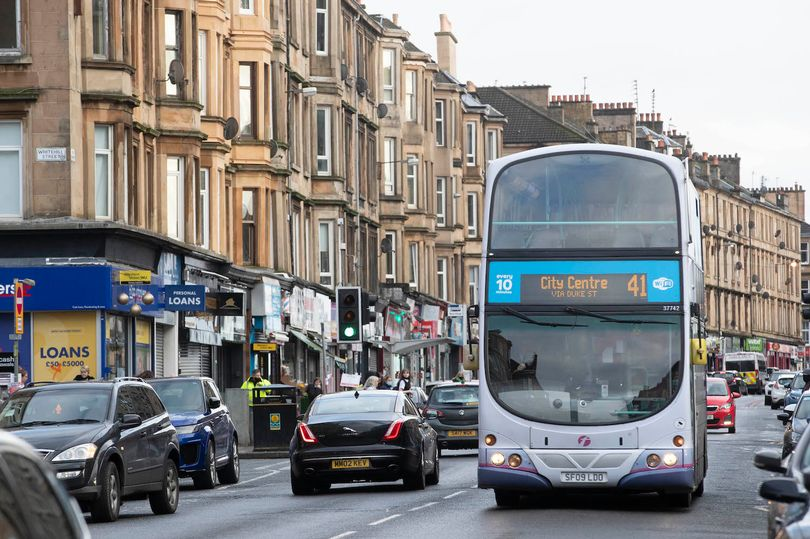


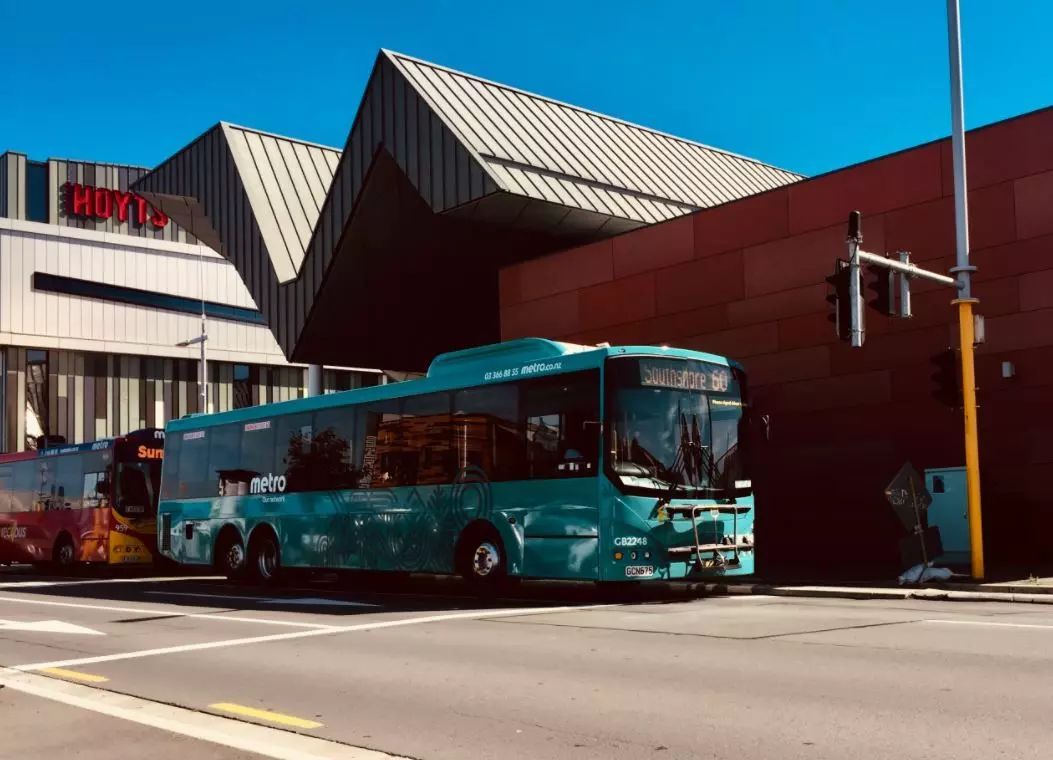

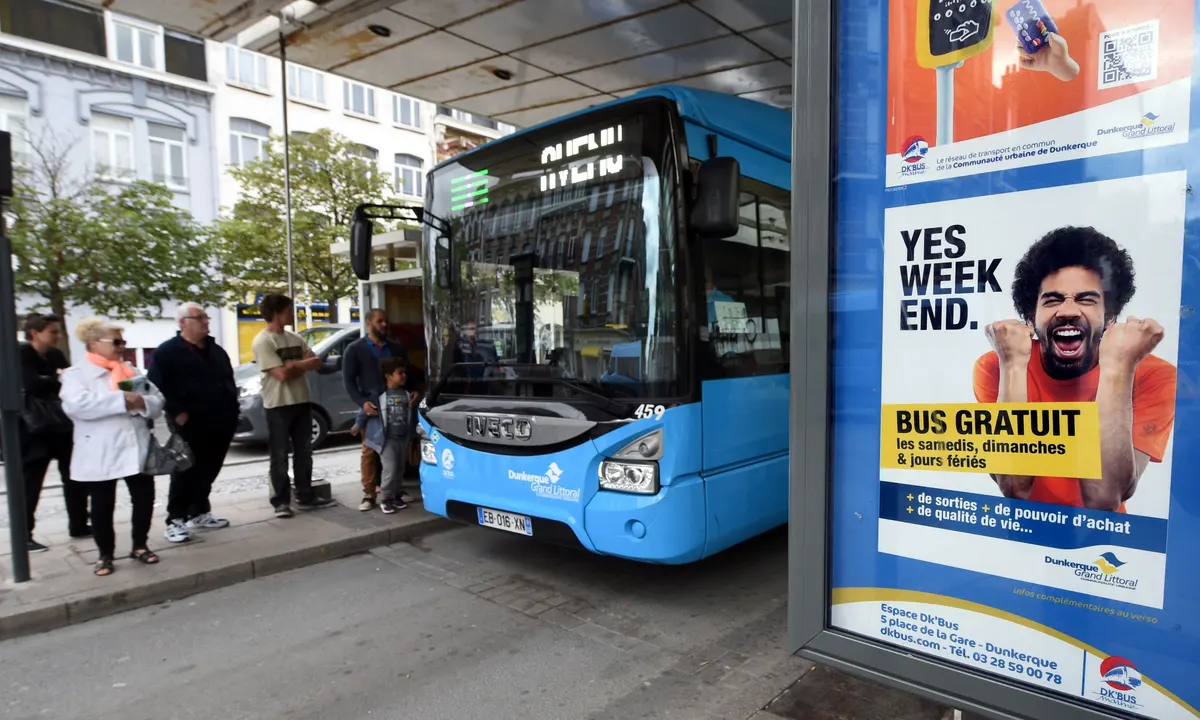

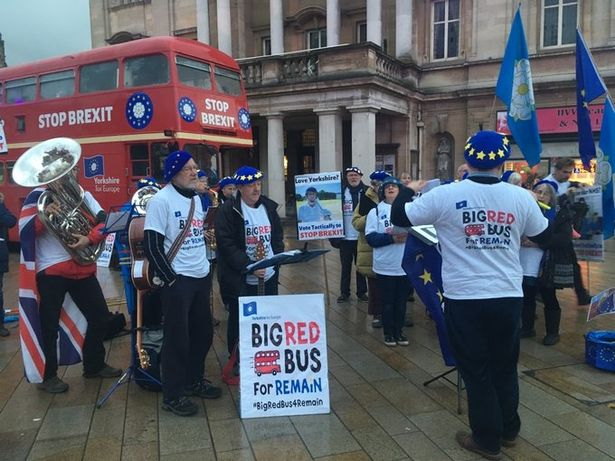

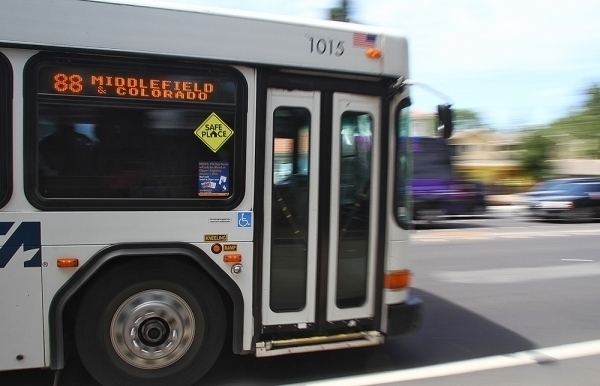

### Planes images

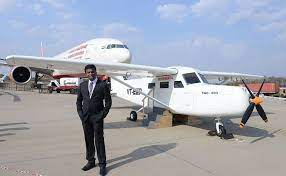

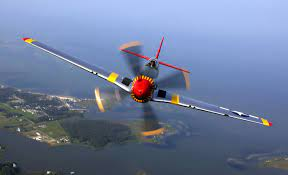

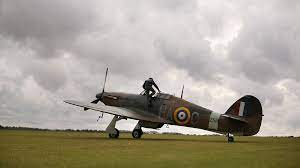

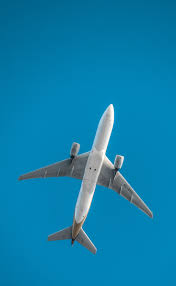

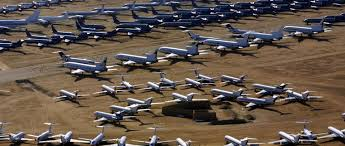

### Motorcycles images

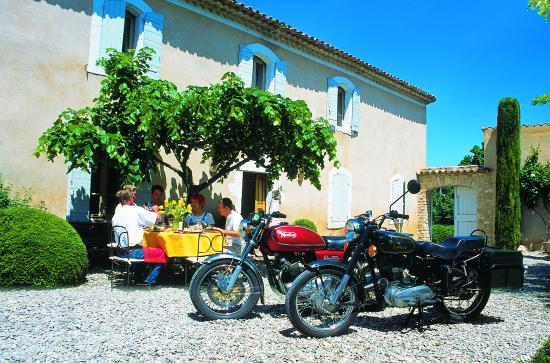

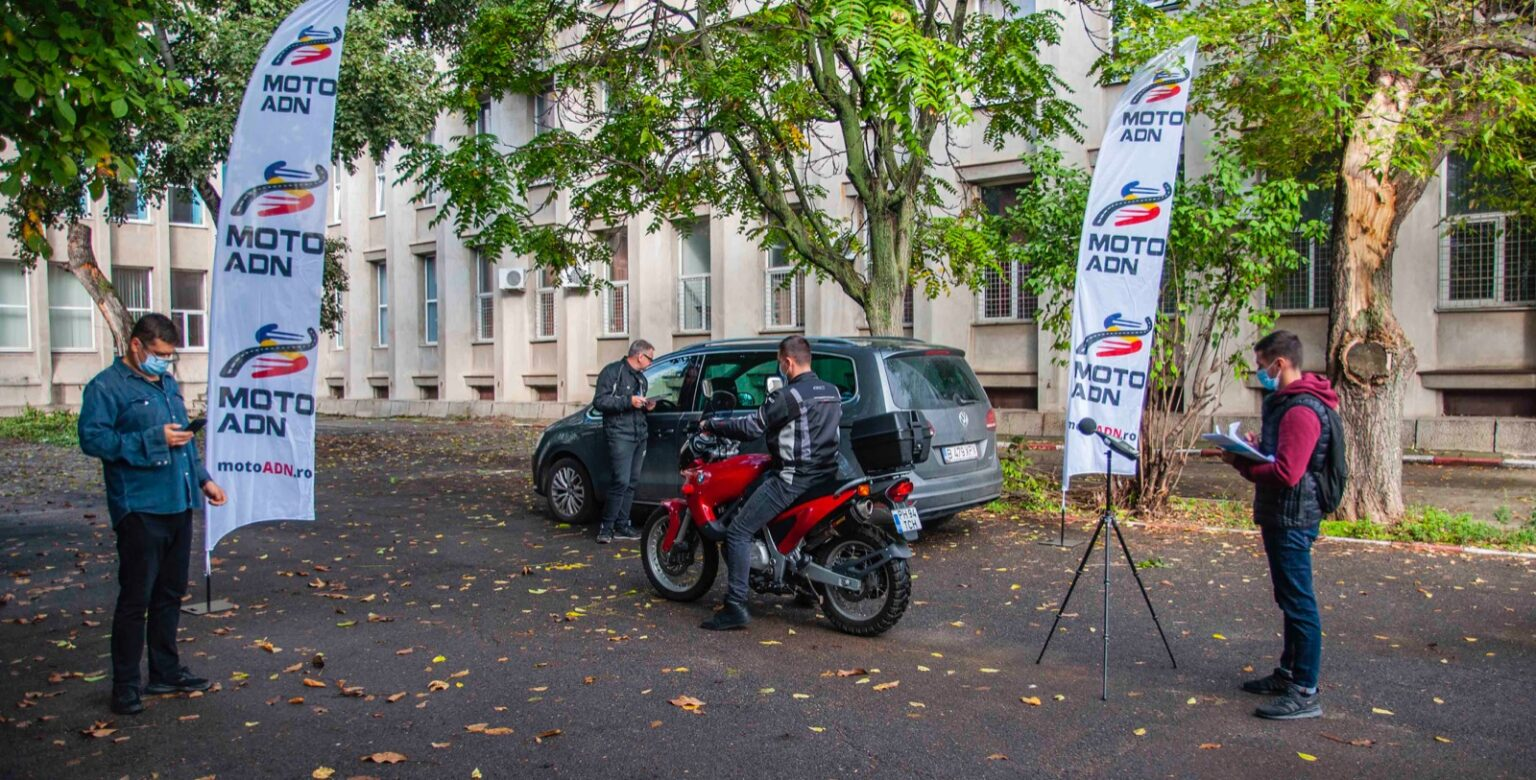

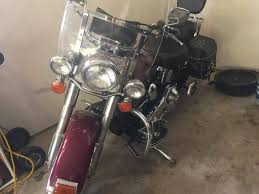

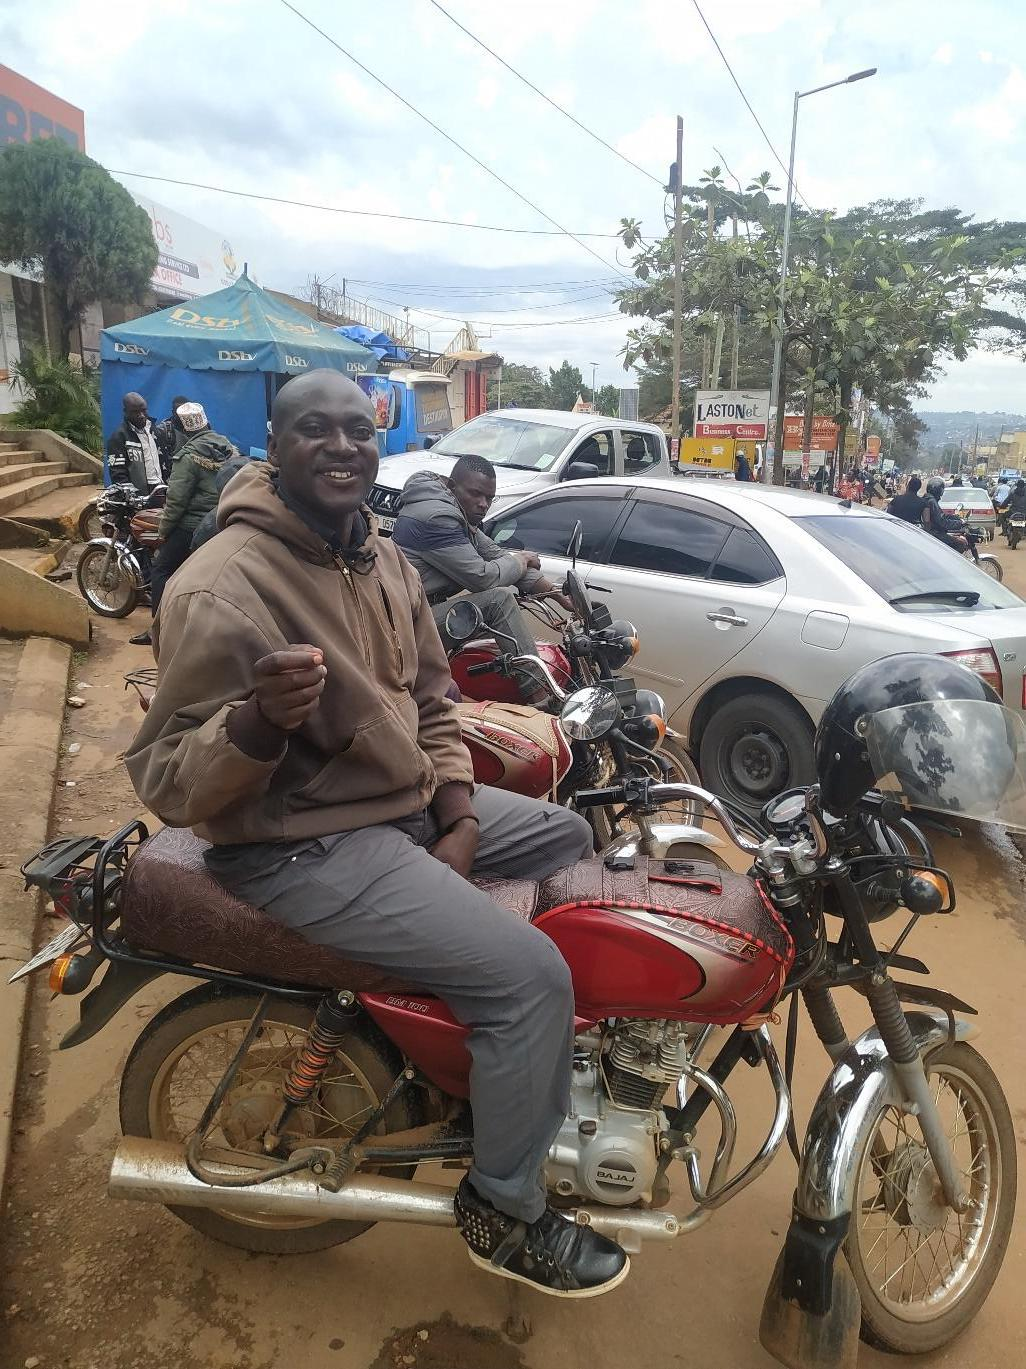

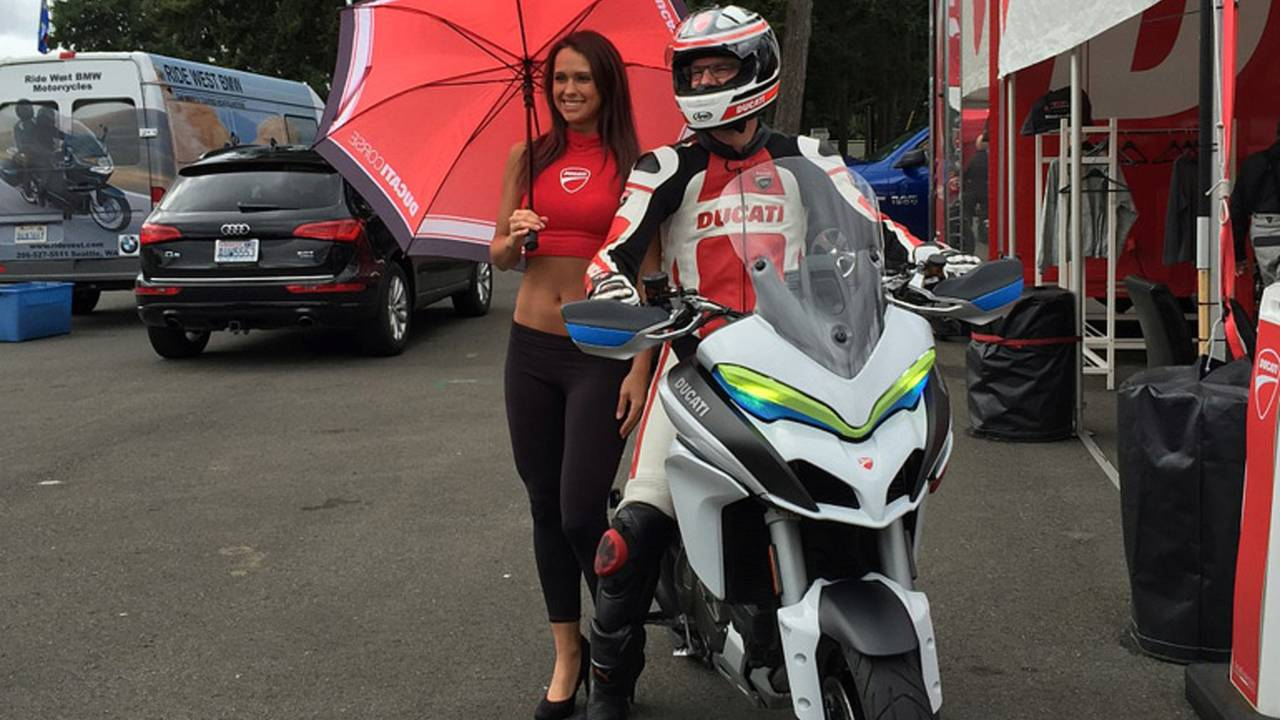

### Train images

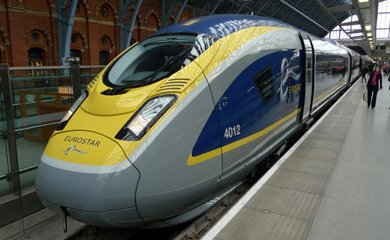

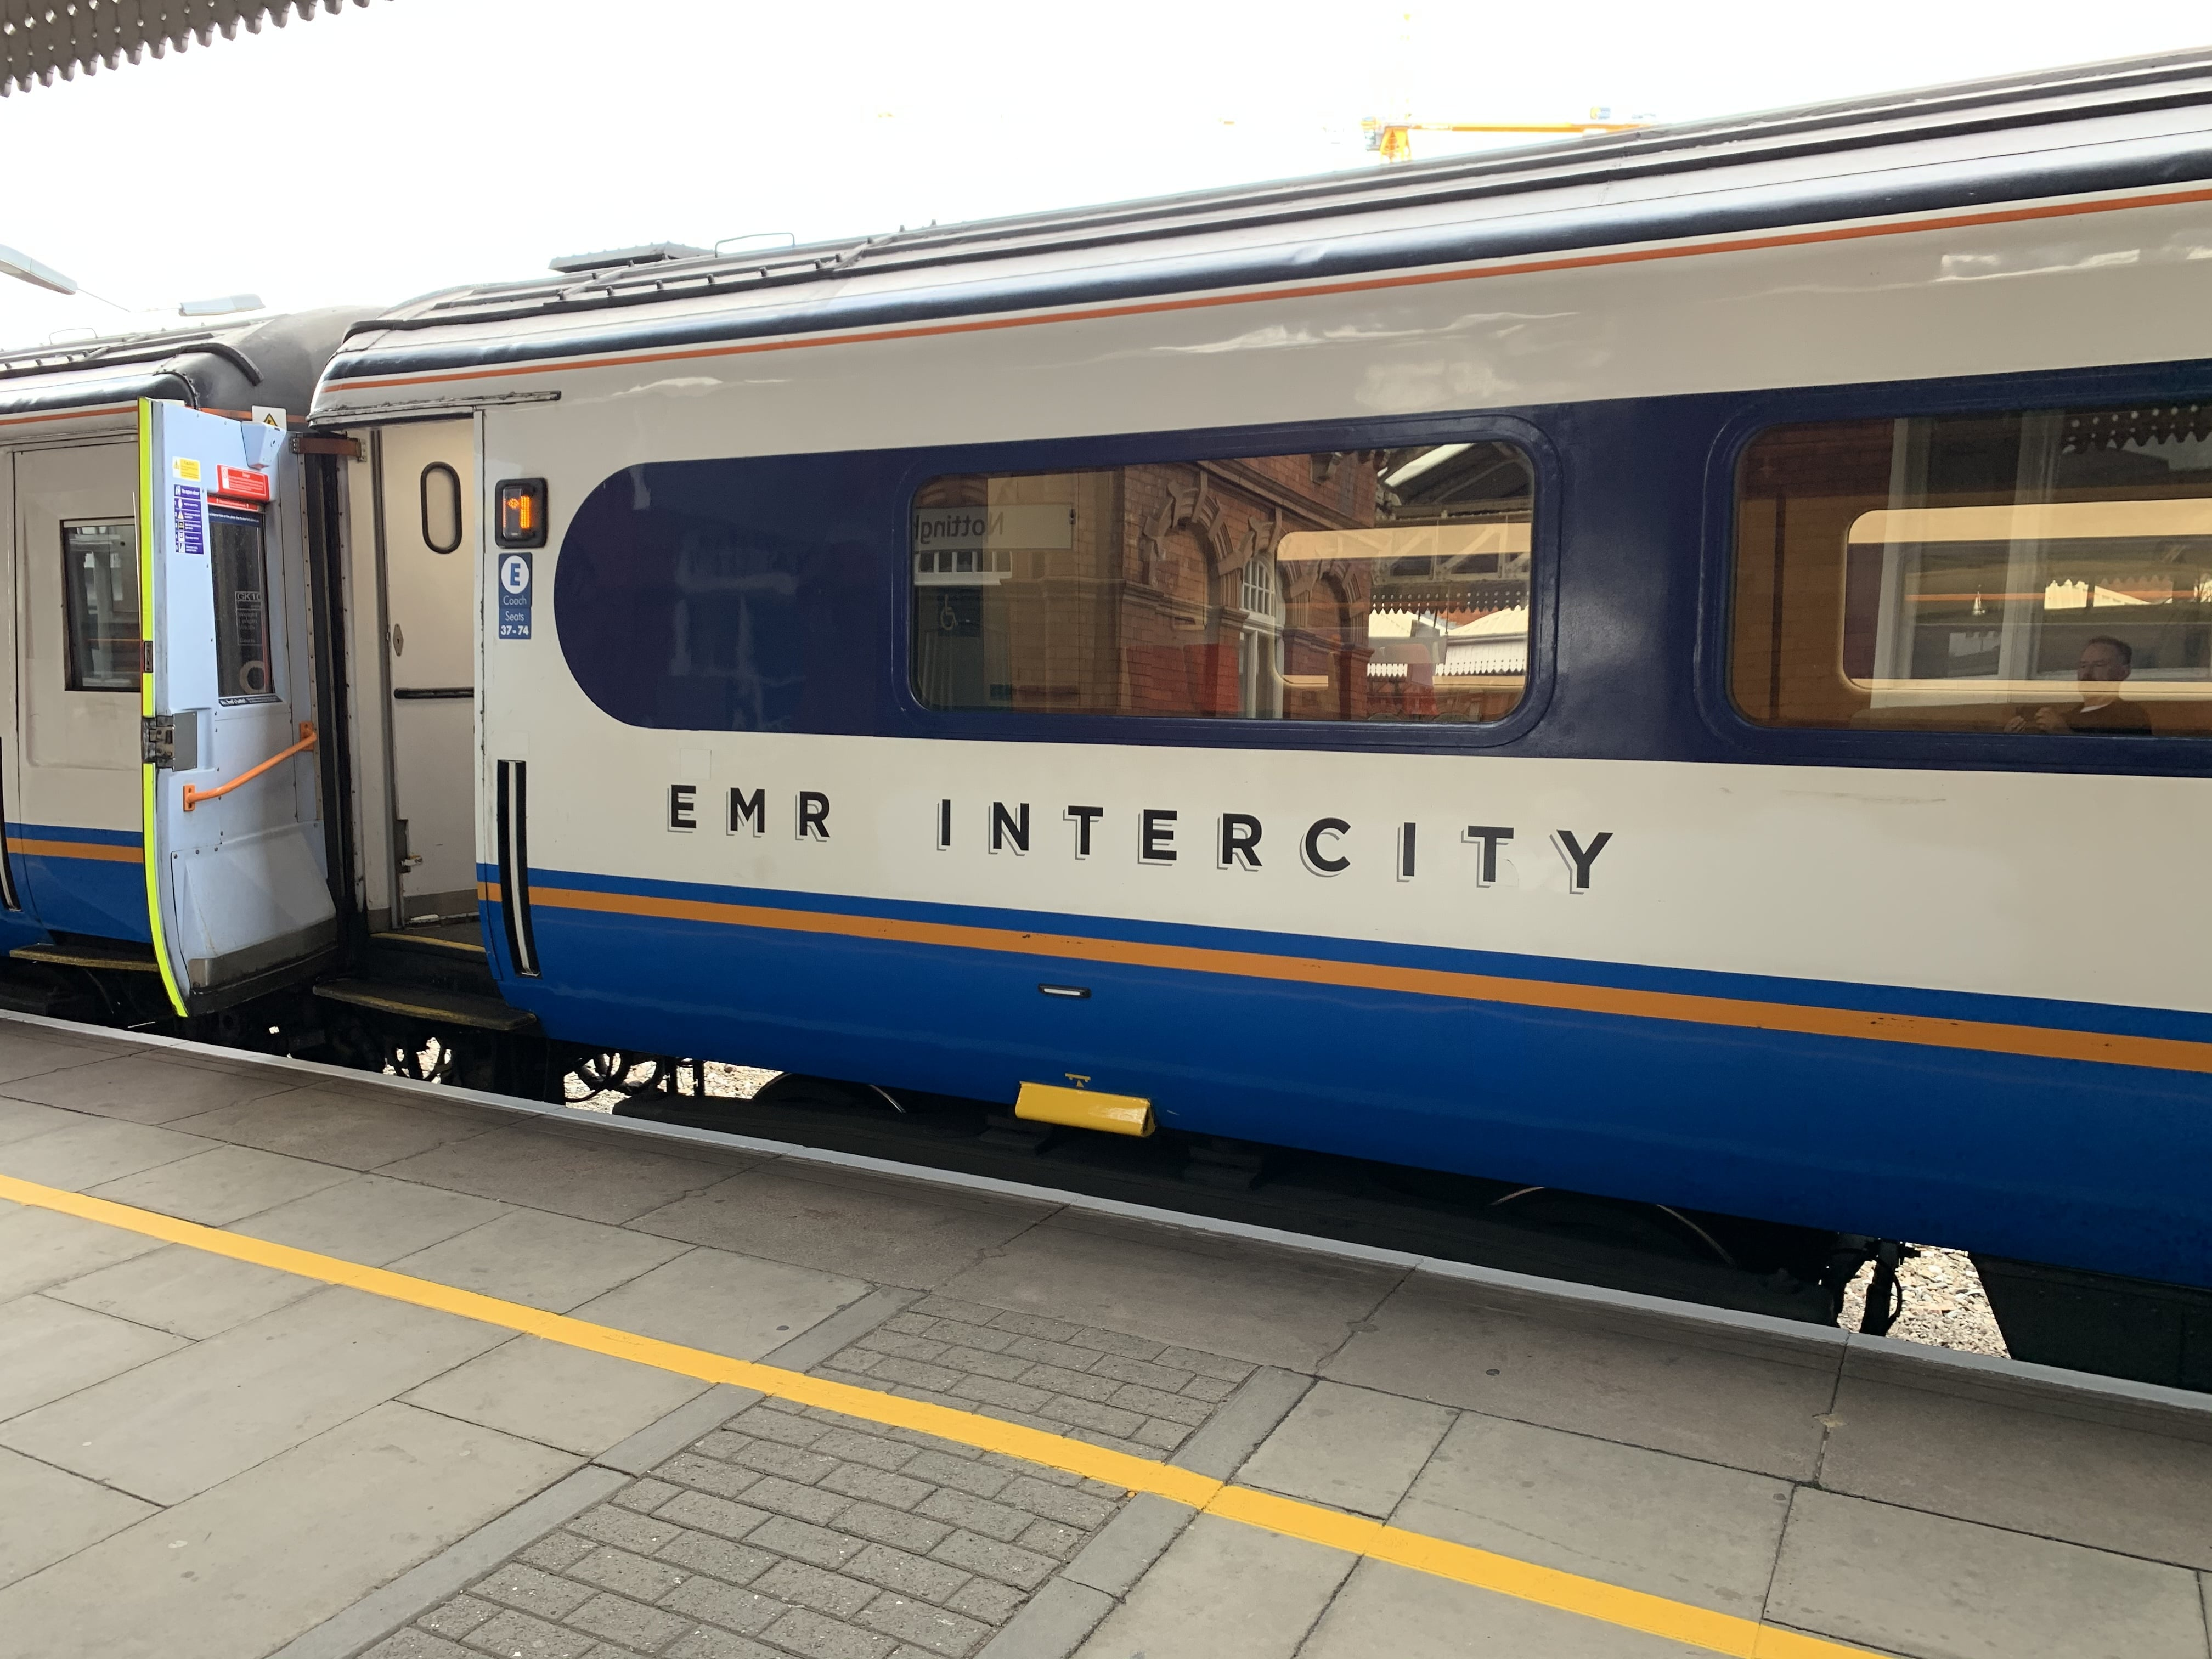

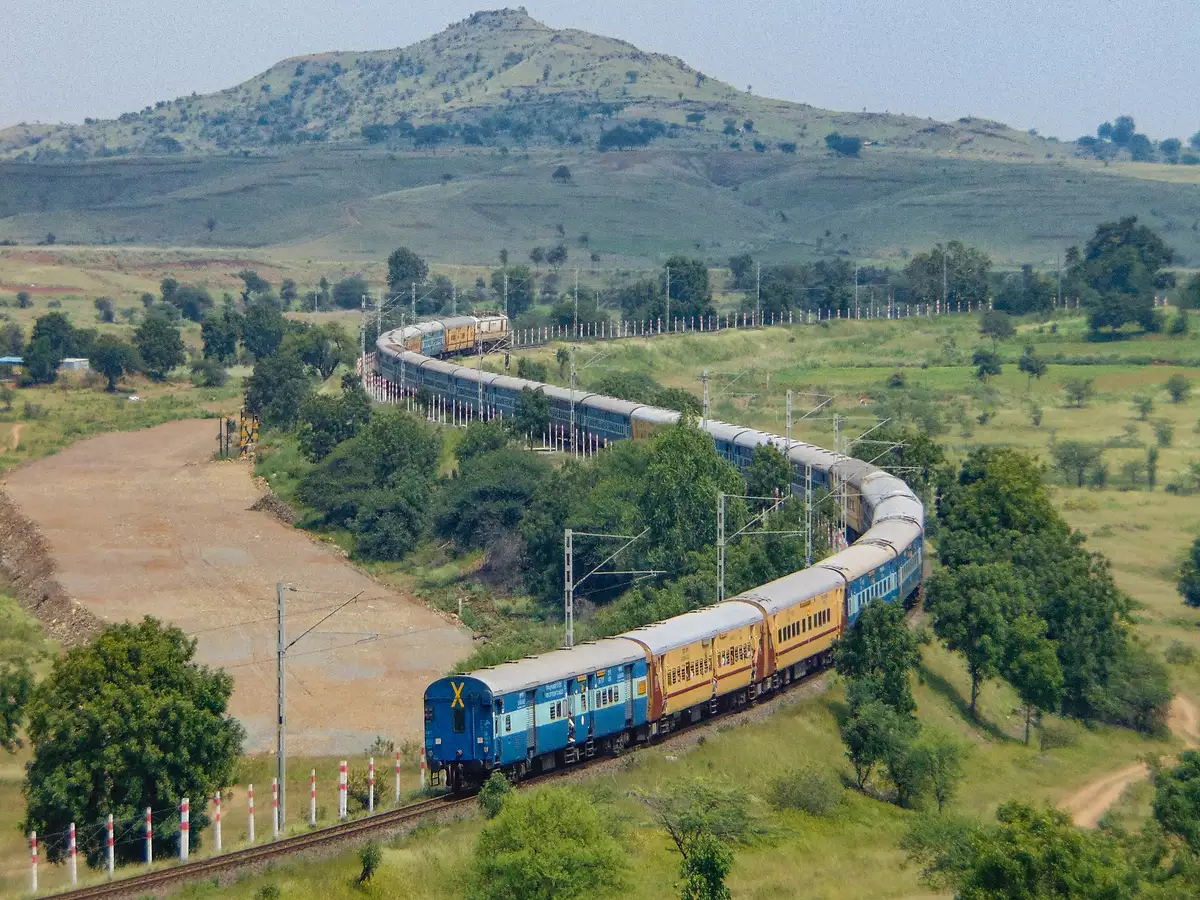

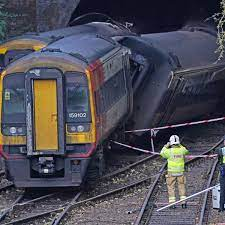

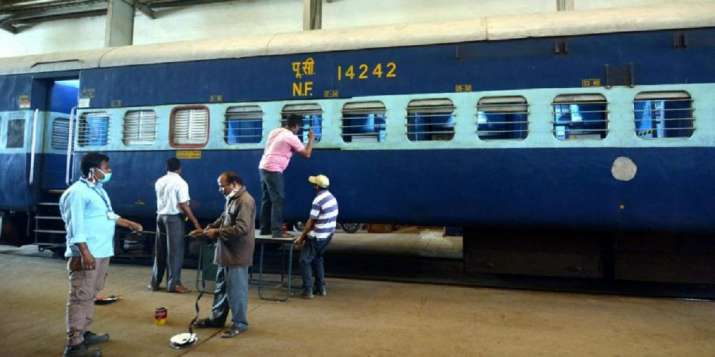

#### Loading the custom dataset 

In [36]:
vehicle_2_dir = './vehicle_images_2'

batch_size = 32
img_height = 160
img_width = 160

train_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
    vehicle_2_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds_2 = tf.keras.preprocessing.image_dataset_from_directory(
    vehicle_2_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
class_names = train_ds_2.class_names
class_names

Found 20 files belonging to 4 classes.
Using 16 files for training.
Found 20 files belonging to 4 classes.
Using 4 files for validation.


['bus', 'motorcycles', 'planes', 'train']

In [38]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_2 = train_ds_2.cache().shuffle(3500).prefetch(buffer_size=AUTOTUNE)
valid_ds_2 = val_ds_2.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds_2.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

num_classes = len(class_names)

0.0 1.0


In [39]:
history_custom = model.fit(train_ds_2,
                        epochs=total_epochs + 10,
                        initial_epoch=history.epoch[-1],
                        validation_data=val_ds_2)

Epoch 10/30
1/1 [==============================] - 0s 197ms/step - loss: 0.1287 - accuracy: 0.9231 - val_loss: 0.1009 - val_accuracy: 1.0000
Epoch 11/30
1/1 [==============================] - 0s 178ms/step - loss: 0.2465 - accuracy: 0.8462 - val_loss: 0.1232 - val_accuracy: 1.0000
Epoch 12/30
1/1 [==============================] - 0s 187ms/step - loss: 0.1302 - accuracy: 1.0000 - val_loss: 0.1426 - val_accuracy: 1.0000
Epoch 13/30
1/1 [==============================] - 0s 173ms/step - loss: 0.1813 - accuracy: 1.0000 - val_loss: 0.1556 - val_accuracy: 1.0000
Epoch 14/30
1/1 [==============================] - 0s 178ms/step - loss: 0.0912 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 1.0000
Epoch 15/30
1/1 [==============================] - 0s 181ms/step - loss: 0.1583 - accuracy: 1.0000 - val_loss: 0.1774 - val_accuracy: 1.0000
Epoch 16/30
1/1 [==============================] - 0s 178ms/step - loss: 0.0752 - accuracy: 1.0000 - val_loss: 0.1861 - val_accuracy: 1.0000
Epoch 17/30
1

(13, 160, 160, 3)
(13,)


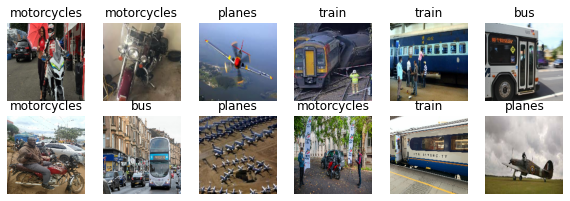

In [46]:
plt.figure(figsize=(10, 10))
for images, labels, in train_ds_2.take(1):
    for i in range(12):
        ax = plt.subplot(6, 6, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
for image_batch, labels_batch in train_ds_2:
    print(image_batch.shape)
    print(labels_batch.shape)
    break